<a id='index'></a>
##### Index
* <a href='#introduction'>Introduction</a>
* <a href='#data'>Processed data</a>
    * <a href='#data:load'>Data loading</a>
    * <a href='#data:visualization'>Data visualization</a>


* <a href='#model_1'>Model definition</a>


<a href='#index'>...</a>
<a id='introduction'></a>
# Introduction

**Imports**

In [21]:
import pandas as pd
import sklearn
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
import warnings
from ipywidgets import IntProgress
from IPython import display
#############
from sklearn.svm import OneClassSVM
from pyod.models import ocsvm

from sklearn.metrics import f1_score, precision_score,  recall_score, make_scorer, roc_curve, auc
import time
import os
from IPython.display import Image

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

**Environment configuration**

In [2]:
def set_display_range(range_columns=pd.options.display.max_columns, range_rows=pd.options.display.max_rows, reset_columns=0, reset_rows=0):
    pd.set_option('display.max_columns', range_columns)
    pd.set_option('display.max_rows', range_rows)
    if (reset_columns): pd.reset_option('display.max_columns')
    if (reset_rows): pd.reset_option('display.max_rows')

set_display_range(range_columns=None)

<a href='#index'>...</a>
<a id='data'></a>
# Processed data

<a id='data:load'></a>
## Data loading

![multistarts](media/multistart.png "multistarts")

In [3]:
root_folder_proc = '../OneClass/OneClass_'

# oc_42
df_oc42_X_train = pd.read_csv(root_folder_proc+'42/X_train_42.csv', sep=';')
df_oc42_X_test = pd.read_csv(root_folder_proc+'42/X_test_42.csv', sep=';')
df_oc42_Y_train = pd.read_csv(root_folder_proc+'42/y_train.csv', sep=';')
df_oc42_Y_test = pd.read_csv(root_folder_proc+'42/y_test.csv', sep=';')

# oc_89
df_oc89_X_train = pd.read_csv(root_folder_proc+'89/X_train_89.csv', sep=';')
df_oc89_X_test = pd.read_csv(root_folder_proc+'89/X_test_89.csv', sep=';')
df_oc89_Y_train = pd.read_csv(root_folder_proc+'89/y_train.csv', sep=';')
df_oc89_Y_test = pd.read_csv(root_folder_proc+'89/y_test.csv', sep=';')

# oc_101
df_oc101_X_train = pd.read_csv(root_folder_proc+'101/X_train_101.csv', sep=';')
df_oc101_X_test = pd.read_csv(root_folder_proc+'101/X_test_101.csv', sep=';')
df_oc101_Y_train = pd.read_csv(root_folder_proc+'101/y_train.csv', sep=';')
df_oc101_Y_test = pd.read_csv(root_folder_proc+'101/y_test.csv', sep=';')

# oc_151
df_oc151_X_train = pd.read_csv(root_folder_proc+'151/X_train_151.csv', sep=';')
df_oc151_X_test = pd.read_csv(root_folder_proc+'151/X_test_151.csv', sep=';')
df_oc151_Y_train = pd.read_csv(root_folder_proc+'151/y_train.csv', sep=';')
df_oc151_Y_test = pd.read_csv(root_folder_proc+'151/y_test.csv', sep=';')

# oc_151
df_oc223_X_train = pd.read_csv(root_folder_proc+'223/X_train_223.csv', sep=';')
df_oc223_X_test = pd.read_csv(root_folder_proc+'223/X_test_223.csv', sep=';')
df_oc223_Y_train = pd.read_csv(root_folder_proc+'223/y_train.csv', sep=';')
df_oc223_Y_test = pd.read_csv(root_folder_proc+'223/y_test.csv', sep=';')

In [4]:
target_df = [(df_oc42_Y_train, df_oc42_Y_test), (df_oc89_Y_train, df_oc89_Y_test), (df_oc101_Y_train, df_oc101_Y_test), (df_oc151_Y_train, df_oc151_Y_test), (df_oc223_Y_train, df_oc223_Y_test)]
content_df = [(df_oc42_X_train, df_oc42_X_test), (df_oc89_X_train, df_oc89_X_test), (df_oc101_X_train, df_oc101_X_test), (df_oc151_X_train, df_oc151_X_test), (df_oc223_X_train, df_oc223_X_test)]
random_state = [42, 89, 101, 151, 189]

CORE_collection = {}
# CORE_collection structure: dictionary of (float) list
# # CORE_collection[@random_state] = list
# Example: 
# CORE_collection = {42: [1,2,3,4...], 89: [6,9,23,34,...], etc}

X_collection = {}
# X_collection structure: dictionary of (float)-list touple
# X_collection[@random_state] = (X_train_df, Y_train_df)

Y_collection = {}              
# Y_collection structure: dictionary of (float)-list touple
# Y_collection[@random_state] = (Y_train_df, Y_train_df)

for Y, X, RS in zip(target_df, content_df, random_state):
    Y[0].loc[Y[0]['ED0DISWHY']==0.0]=-1
    Y[1].loc[Y[1]['ED0DISWHY']==0.0]=-1
    Y[0]['ED0DISWHY'] = Y[0]['ED0DISWHY'].astype("int64")
    Y[1]['ED0DISWHY'] = Y[1]['ED0DISWHY'].astype("int64")
              
    CORE_collection[RS] = (X[0]['CORE'],X[1]['CORE'])
    X_collection[RS] = (X[0].drop(columns=['CORE']), X[1].drop(columns=['CORE']))
    Y_collection[RS] = (Y[0], Y[1])
    
X_data = pd.concat([X_collection[42][0], X_collection[42][1]],axis=0)
Y_data = pd.concat([Y_collection[42][0], Y_collection[42][1]],axis=0)


<a id='data:visualization'></a>
## Data visualization

**Function definition**

In [5]:
def column_percentage(df, column, main_label):
    try:
        return len(df.loc[df[column]==main_label])/len(df)
    except:
        return -1

In [6]:
def plot_zero_relevance(df, columns, dim_x, dim_y, main_title='SAMPLE TITLE', titles=None, verbose=0):
    '''
    Prints histogram for every columns desired in a dataframe.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns
              
    dim_x: int
           Size of the x axis of plot grid. 
    
    dim_y: int
           Size of the y axis of plot grid.
           
    main_title: String
                Title of the figure.
                
    titles: String[]
            Array containing the subtitle of every plot.
    
    verbose: int
             1 to activate verbose mode. Otherwise, hide prints.
                
    '''
    col = 0
    total = df.shape[0]
    if (verbose) : print("Number of 0's:")
    if (titles == None) : titles=columns 
    fig, axes = plt.subplots(dim_x, dim_y, figsize=(16,8))
    fig.suptitle(main_title)
    try:
        for i in range(dim_x):
            for j in range(dim_y):
                if (verbose):
                    print("* "+titles[col]+" \t{} ({:.2f}%)".format(sum(df[columns[col]]==0),sum(df[columns[col]]==0)/total*100))
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    ax = sns.distplot(ax=axes[i,j], x=df[columns[col]], color='#388E3C') # hist=True
                if (ax.lines != []):
                    kde_x, kde_y = ax.lines[0].get_data()
                    ax.fill_between(kde_x, kde_y, where=(kde_x<max(df[columns[col]])*0.1), interpolate=True, color='#EF9A9A')
                axes[i,j].set_title(titles[col])  
                col+=1
    except:
        pass

In [7]:
def zero_relevance(df, columns):
    '''
    Prints 0 value percentage in defined columns.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns to print  
    '''
    print("Percentage of 0's per column:")
    total = df.shape[0]
    for col in columns:
        print("* "+col+" \t{} ({:.2f}%)".format(sum(df[col]==0),sum(df[col]==0)/total*100))
               

In [8]:
def plot_pair_individual(X, Y, x1, x2):
    '''
    Plots a pair-plot type grid axes for 2 features and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    x1:  String
        Name of the first column
        
    x1:  String
        Name of the second column
    '''
    fig, ax = plt.subplots()
    index = Y.index
    normal_index = index[Y['ED0DISWHY']==1]
    anomaly_index = index[Y['ED0DISWHY']==-1]
    X_normal = X.iloc[normal_index]
    X_anomaly = X.iloc[anomaly_index]
    ax.scatter(X_anomaly[x1], X_anomaly[x2], c='plum', alpha=0.7, label='Anomaly samples')
    ax.scatter(X_normal[x1], X_normal[x2], c='rebeccapurple', alpha=0.7, label='Positive samples')
    plt.xlabel(x1)
    plt.ylabel(x2)
    leg = ax.legend()

In [9]:
def plot_box_plot(X, Y, features, save=0):
    '''
    Plots plot-box type grid axes for 1 feature and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    features: String[]
              Array containning the names of the desired columns to print
  
    save: int
            1 value, save plots. Otherwise, print plots.
    '''
    path = './boxplots'
    if (not os.path.isdir(path)):
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Successfully created the directory %s " % path)
    for feat in features:
        boxp = sns.boxplot(y=X[feat],x=Y['ED0DISWHY'])
        if (save):
            fig = boxp.get_figure()
            fig.savefig(path+'/bp_'+feat+'.png')
            plt.close()
        else:
            plt.show()

# plot_box_plot(X=X_collection[42][0], Y=Y_collection[42][0], features=X_collection[42][0].columns, save=1

**0 value percetange per column.**

Printing the percentage of samples with value 0 per all columns. Excluiding those features which have 0 as a suitable value.

In [10]:
zero_relevance_columns = ['CT0000ADW', 'CT00000AP', 'CT000APTT', 'CT00000BT', 'CT000CHCM', 'CT00000DD', 'CT0000GGT', 'CT0000GLU', 'CT0000GOT', 'CT0000GPT', 'CT0000HCM', 'CT000HCTO', 'CT0000HEM', 'CT0000HGB', 'CT0000INR', 'CT000000K', 'CT0000LDH', 'CT000LEUC', 'CT0000LIN', 'CT000LINP', 'CT00MONOP', 'CT00000NA', 'CT0000NEU', 'CT000NEUP', 'CT0000PCR', 'CT000PLAQ', 'CT00000TP', 'CT000000U', 'CT0000VCM', 'CT0000VPM', 'CTHSDXXRATE','CTHSDXXSAT']
zero_relevance(X_data, zero_relevance_columns)

Percentage of 0's per column:
* CT0000ADW 	0 (0.00%)
* CT00000AP 	0 (0.00%)
* CT000APTT 	0 (0.00%)
* CT00000BT 	0 (0.00%)
* CT000CHCM 	0 (0.00%)
* CT00000DD 	0 (0.00%)
* CT0000GGT 	0 (0.00%)
* CT0000GLU 	0 (0.00%)
* CT0000GOT 	0 (0.00%)
* CT0000GPT 	0 (0.00%)
* CT0000HCM 	0 (0.00%)
* CT000HCTO 	0 (0.00%)
* CT0000HEM 	0 (0.00%)
* CT0000HGB 	0 (0.00%)
* CT0000INR 	0 (0.00%)
* CT000000K 	0 (0.00%)
* CT0000LDH 	0 (0.00%)
* CT000LEUC 	0 (0.00%)
* CT0000LIN 	0 (0.00%)
* CT000LINP 	0 (0.00%)
* CT00MONOP 	0 (0.00%)
* CT00000NA 	0 (0.00%)
* CT0000NEU 	0 (0.00%)
* CT000NEUP 	0 (0.00%)
* CT0000PCR 	0 (0.00%)
* CT000PLAQ 	0 (0.00%)
* CT00000TP 	0 (0.00%)
* CT000000U 	0 (0.00%)
* CT0000VCM 	0 (0.00%)
* CT0000VPM 	0 (0.00%)
* CTHSDXXRATE 	0 (0.00%)
* CTHSDXXSAT 	0 (0.00%)


**Pairwise representation of features, visualizing the relationship with the target class.**

Individual pairs.

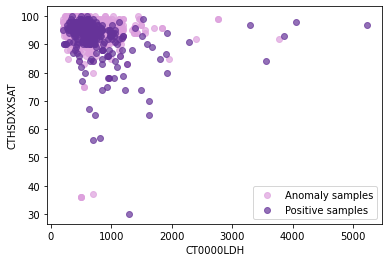

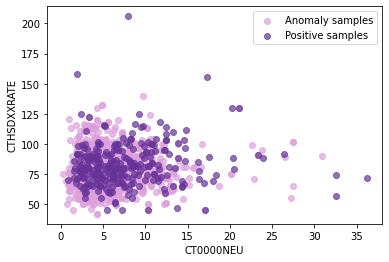

In [11]:
plot_pair_individual(X_data, Y_data, 'CT0000LDH', 'CTHSDXXSAT')
plot_pair_individual(X_data, Y_data, 'CT0000NEU', 'CTHSDXXRATE')

Record features taken during admission and registered information about diagnosis and procedements (according to CIE10 codification).

Text(0.5, 1.08, "Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)")

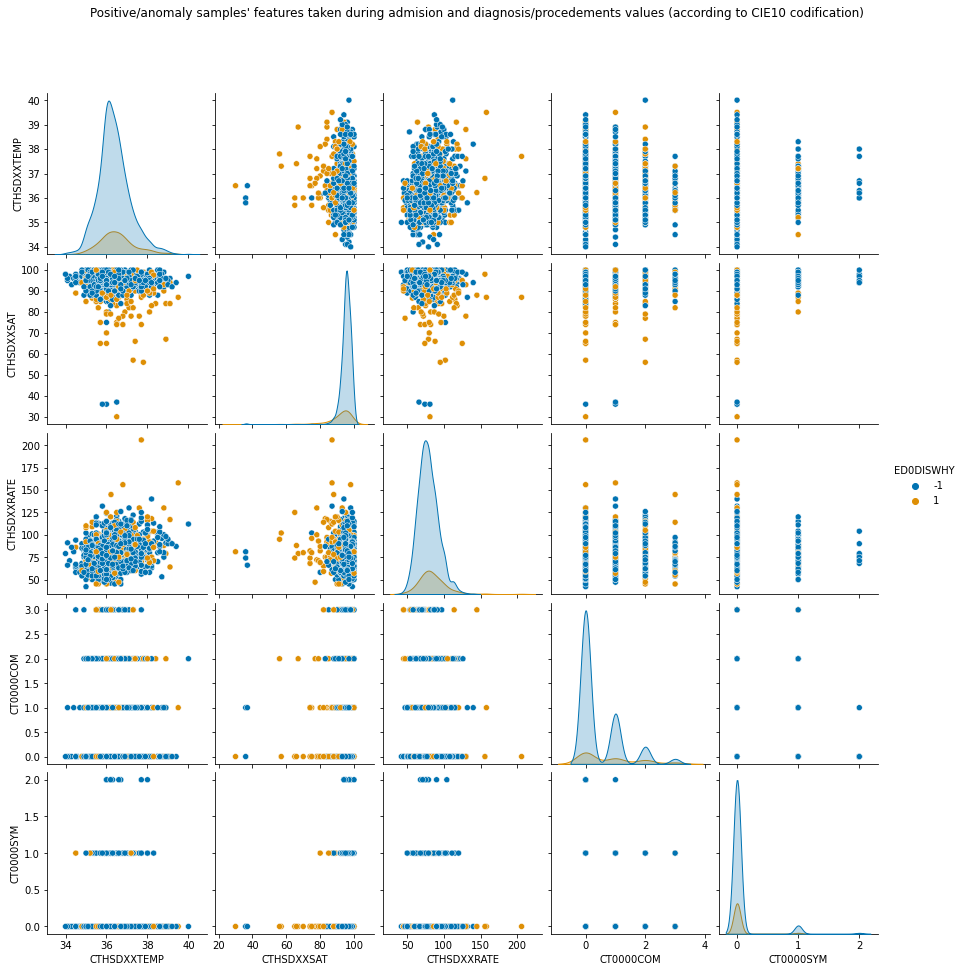

In [12]:
pp = sns.pairplot(pd.concat([X_data[['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CT0000COM','CT0000SYM']], Y_data],axis=1), hue='ED0DISWHY', palette='colorblind')
pp.fig.suptitle("Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)", y=1.08)

Distribution representation of features for positive and anomaly samples.


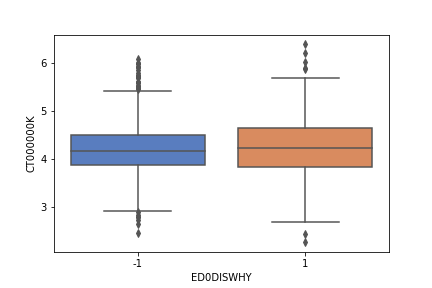

In [13]:
Image(filename='boxplots/bp_CT000000K.png')

<a href='#index'>...</a>
<a id='model_1'></a>
# Model definition

In [14]:
 # PRUEBA PRINT PROPORCIONES CLASE ANOMALY EN SUBSETS
 '''   
                print('OLD TRAIN/TEST')
                old_train = df_Y.iloc[train_inner]
                old_test = df_Y.iloc[test_inner]
                print(len(old_train.loc[old_train['ED0DISWHY']==0.0]))
                print(len(old_test .loc[old_test['ED0DISWHY']==0.0]))

                print('NEW TRAIN/TEST')

                good_train = df_Y.iloc[n_train]
                print(len(good_train.loc[good_train['ED0DISWHY']==0.0]))
                good_test = df_Y.iloc[n_test]
                print(len(good_test.loc[good_test['ED0DISWHY']==0.0]))
                print('###################')
'''

"   \n               print('OLD TRAIN/TEST')\n               old_train = df_Y.iloc[train_inner]\n               old_test = df_Y.iloc[test_inner]\n               print(len(old_train.loc[old_train['ED0DISWHY']==0.0]))\n               print(len(old_test .loc[old_test['ED0DISWHY']==0.0]))\n\n               print('NEW TRAIN/TEST')\n\n               good_train = df_Y.iloc[n_train]\n               print(len(good_train.loc[good_train['ED0DISWHY']==0.0]))\n               good_test = df_Y.iloc[n_test]\n               print(len(good_test.loc[good_test['ED0DISWHY']==0.0]))\n               print('###################')\n"

In [22]:
def oc_split(Y, train, test, normal):
    indexed_train = zip(np.arange(0,train.shape[0],1), train)
    # Index to remove from train set
    del_index = []

    for train_index, df_index in tqdm(indexed_train, total=train.shape[0], desc = 'Transfering anomaly samples from train to test'): 
        sample = Y.iloc[df_index]
        if (sample['ED0DISWHY']!=normal):
            # Append anomaly samples from train to test
            test = np.append(test, df_index)
            # Update train (anomaly) indexes
            del_index.append(train_index)
    # Remove anomaly samples from train
    train = np.delete(train, del_index, 0)
    return train, test


In [53]:
def nested_cv(X, Y, outer_folds, inner_folds, model, parameters, one_class=0, normal_target=1):

    outer_loop=1
    max_score = -1
    score_outer = []
    inner_results = []

    # Define outer-loop
    skfold_outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=1)
    for train_outer, test_outer in skfold_outer.split(X, Y):
        display.clear_output(wait=True)
        print("Outer loop folds: {}/{}".format(outer_loop, outer_folds))
        
        # Outer-loop data retrieve
        X_train_outer, X_test_outer = X.iloc[train_outer], X.iloc[test_outer]
        Y_train_outer, Y_test_outer = Y.iloc[train_outer], Y.iloc[test_outer]
        
        # Define inner loop
        skfold_inner = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=1)
        
        # Transfering anomaly samples from train to test subsets.
        if (one_class):
            skfold_inner_cv = list()
            for train_inner, test_inner in skfold_inner.split(X_train_outer, Y_train_outer):
                # List containing indexes with train subset clear of anomaly samples
                skfold_inner_cv.append((oc_split(Y, train_inner, test_inner, normal_target)))
        else:
            skfold_inner_cv = skfold_inner
            
        # GRIDSEARCH
        # Obtain best model
        scorer = make_scorer(f1_score, pos_label=1)
        gsearch = GridSearchCV(model, param_grid=parameters, cv=skfold_inner_cv, scoring=scorer)
        gsearch.fit(X.iloc[train_outer], Y.iloc[train_outer])
        inner_results.append(gsearch.cv_results_)
        
        # Best estimator
        estimator = gsearch.best_estimator_
        pred_y = estimator.predict(X_test_outer)
        # print('Predited Y: \n {} \n'.format(pred_y))
        # print('Ground truth Y: \n {} \n'.format(df_Y.iloc[test_outer]))
        score = f1_score(Y.iloc[test_outer], pred_y)
        score_outer.append(score)
        if (score>=max(score_outer)): best_estimator = estimator
            
        outer_loop+=1
        #ime.sleep(10)
    display.clear_output(wait=True)
    
    print("Summary:")
    for i in range(outer_folds):
        best_ifold = np.where(inner_results[i]['rank_test_score'] == 1)[0][0]
        print("Outer fold nº{}.".format(i+1))
        print("Parameters (best of cv): {}".format(inner_results[i]['params'][best_ifold]))
        print("Score (best of cv): {:.3}±{:.2}".format(inner_results[i]['mean_test_score'][best_ifold], inner_results[i]['std_test_score'][best_ifold]))
        print("Score (outer): {:.4}\n".format(score_outer[i]))
    return best_estimator
        

**Outlierness representation**

<AxesSubplot:ylabel='Count'>

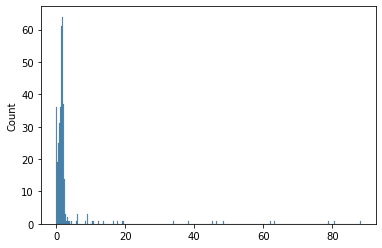

In [17]:
model = OneClassSVM(nu=0.5)

train = X_collection[42][0].loc[Y_collection[42][0]['ED0DISWHY']==1]
model.fit(train)

# OUTLIER-SCORE IN OCSVM 
# https://activisiongamescience.github.io/2015/12/23/Unsupervised-Anomaly-Detection-SOD-vs-One-class-SVM/#sklearn-Users-Beware

# Computing outlier-score in OCSVM
MAX = max(model.decision_function(X_collection[42][1]))
outlier_score = MAX - model.decision_function(X_collection[42][1])

# print(outlier_score)

sns.histplot(data=outlier_score)


# fpr, tpr, thresholds = roc_curve(Y_collection[42][1], outlier_score, pos_label=1)
# roc_auc = metrics.auc(fpr, tpr)
# print(auc_ocsvm)

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

# print("#########")


In [63]:
ocsvm_pyod = OneClassSVM()


ocsvm_pyod_params= {
        'nu': [10**i for i in range(-40,0)],
        'gamma': [10**i for i in range(-40,0)]
    }

estimator_ocsvm = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=ocsvm_pyod, parameters=ocsvm_pyod_params, one_class=1, normal_target = 1)


ocsvm_pyod.fit(X_collection[42][0])
outlier_score = ocsvm_pyod.decision_function(X_collection[42][1])


Summary:
Outer fold nº1.
Parameters (best of cv): {'gamma': 1e-12, 'nu': 0.1}
Score (best of cv): 0.325±0.028
Score (outer): 0.2794

Outer fold nº2.
Parameters (best of cv): {'gamma': 1e-11, 'nu': 0.01}
Score (best of cv): 0.335±0.0033
Score (outer): 0.2667

Outer fold nº3.
Parameters (best of cv): {'gamma': 1e-12, 'nu': 0.01}
Score (best of cv): 0.295±0.026
Score (outer): 0.2719

Outer fold nº4.
Parameters (best of cv): {'gamma': 1e-11, 'nu': 0.01}
Score (best of cv): 0.33±0.025
Score (outer): 0.2577

Outer fold nº5.
Parameters (best of cv): {'gamma': 1e-12, 'nu': 0.01}
Score (best of cv): 0.332±0.0085
Score (outer): 0.3185



<AxesSubplot:xlabel='score', ylabel='type'>

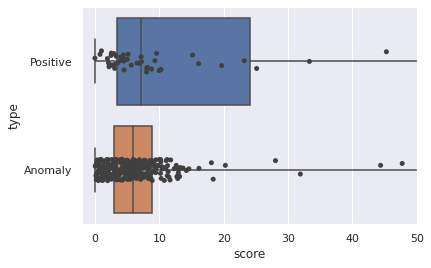

In [140]:
outlier_score =  ocsvm_pyod.decision_function(X_collection[42][1])

sns.set()
# OUTLIER SCORE TRANSFORMATION: lower score means bigger outlier
MAX = max(ocsvm_pyod.decision_function(X_collection[42][1]))
outlier_score = MAX - ocsvm_pyod.decision_function(X_collection[42][1])


index = Y_collection[42][1].index
anomaly_index = index[Y_collection[42][1]['ED0DISWHY']==-1]
positive_index = index[Y_collection[42][1]['ED0DISWHY']==1]
d = {'score':outlier_score[positive_index], 'type':len(outlier_score[positive_index])*['Positive']}
df_positive = pd.DataFrame(data=d)
d = {'score':outlier_score[anomaly_index], 'type':len(outlier_score[anomaly_index])*['Anomaly']}
df_anomaly = pd.DataFrame(data=d)

df_scores = pd.concat([df_positive, df_anomaly])


plt.xlim([-2,50])
sns.boxplot(y='type', x='score', data=df_scores, whis=np.inf)
sns.stripplot(y='type', x='score', data=df_scores, color=".25")


<AxesSubplot:xlabel='score', ylabel='type'>

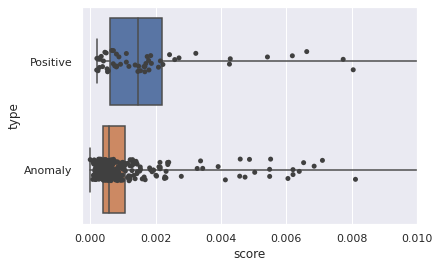

In [141]:
prueba_ocsvm = ocsvm.OCSVM(gamma= 1e-12, nu= 0.01)
prueba_ocsvm.fit(X_collection[42][0])

outlier_score =  prueba_ocsvm.decision_function(X_collection[42][1])

# OUTLIER SCORE TRANSFORMATION: lower score means bigger outlier
MAX = max(prueba_ocsvm.decision_function(X_collection[42][1]))
outlier_score = MAX - prueba_ocsvm.decision_function(X_collection[42][1])

index = Y_collection[42][1].index
anomaly_index = index[Y_collection[42][1]['ED0DISWHY']==-1]
positive_index = index[Y_collection[42][1]['ED0DISWHY']==1]
d = {'score':outlier_score[positive_index], 'type':len(outlier_score[positive_index])*['Positive']}
df_positive = pd.DataFrame(data=d)
d = {'score':outlier_score[anomaly_index], 'type':len(outlier_score[anomaly_index])*['Anomaly']}
df_anomaly = pd.DataFrame(data=d)

df_scores = pd.concat([df_positive, df_anomaly])


plt.xlim([-0.00025, 0.01])
sns.boxplot(y='type', x='score', data=df_scores, whis=np.inf)
sns.stripplot(y='type', x='score', data=df_scores, color=".25")

## Unsupervised models

**UNIVERSE 1**

In [54]:

## Previous

# Define models
# 1SVM
# 'C': [0.1, 1, 100, 1000],
#         'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],

ocsvm_params= {
        #'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 10, 100],
        'nu': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
    }

# Model 1

model = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=OneClassSVM(), parameters=ocsvm_params, one_class=1, normal_target = 1)
prediction = model.predict(X_collection[42][1])
score = f1_score(Y_collection[42][1], prediction)
print("Global score: {}".format(score))
# Model 2

# Model N


Summary:
Outer fold nº1.
Parameters (best of cv): {'nu': 0.4}
Score (best of cv): 0.258±0.0065
Score (outer): 0.2165

Outer fold nº2.
Parameters (best of cv): {'nu': 0.1}
Score (best of cv): 0.239±0.0034
Score (outer): 0.2416

Outer fold nº3.
Parameters (best of cv): {'nu': 0.1}
Score (best of cv): 0.247±0.0062
Score (outer): 0.2437

Outer fold nº4.
Parameters (best of cv): {'nu': 0.1}
Score (best of cv): 0.231±0.0045
Score (outer): 0.223

Outer fold nº5.
Parameters (best of cv): {'nu': 0.1}
Score (best of cv): 0.244±0.0051
Score (outer): 0.2617

Global score: 0.24403183023872677


In [13]:
score

0.06015037593984962

## Supervised models